[<img src="https://user-images.githubusercontent.com/79705081/109483674-d3eea600-7a7f-11eb-9a25-58c50da4cde9.png">](http://edenlibrary.ai/)

## Instructions
To run any of Eden's notebooks, please check the guides on our [Wiki page](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki).<br>
There you will find instructions on how to deploy the notebooks on [your local system](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-Locally), on [Google Colab](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-GColab), or on [MyBinder](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-MyBinder), as well as other useful links, troubleshooting tips, and more.

**Note:** If you find any issues while executing the notebook, don't hesitate to open an issue on Github. We will try to reply as soon as possible.

## Background

In this notebook, we are going to cover a technique called **Transfer Learning**, which generally refers to a process where a machine learning model is trained on one problem, and afterwards, it is reused in some way on a second (probably) related problem (Bengio, 2012). Specifically, in **deep learning**, this technique is used by training only some layers of the pre-trained network. Its promise is that the training will be more efficient and in the best of the cases the performance will be better compared to a model trained from scratch. 

Although the choice of an architecture is an important decision, other hyper-parameters such as the **optimizer** method can play a critical role in deep learning. Basically, optimizers **modify the weights** of the network **given the gradients** and, maybe, additional information, depending on the type of the optimizer. Most optimizers are based on gradient descent, the approach of iteratively decreasing the loss function by following the gradient. Gradient descent can be as simple as subtracting the gradients from the weights, or can also be very sophisticated. The choice of optimizer can dramatically influence the performance of the model. 

In this notebook, we are going to compare (i) a simple optimizer but still powerful and widely used, which is named **Stochastic Gradient Descent (SGD)**, and (ii) a more recent one, which is used in many recent research papers, whose name is **Adaptive Moment Estimation (Adam)**. The difference is that  SGD subtracts the gradient multiplied by the same learning rate from the weights, while Adam computes adaptive learning rates for each parameter. Although theoretically more powerful, Adam introduces two new hyperparameters that complicate the hyperparameter tuning problem.

Check the previous notebook about the same topic but using Tensorflow.

1. https://github.com/Eden-Library-AI/eden_library_notebooks/blob/master/image_classification/nutrient_deficiency_classification-optimizer_comparison-1.ipynb

#### Library Imports

In [25]:
import torch
from torch import nn
from torch import optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

import random
import shutil

RANDOM_SEED = 2021
random.seed(RANDOM_SEED)

<IPython.core.display.Javascript object>

#### Auxiliar functions
Check the docstrings for more information.

In [26]:
SRC_PATH = "../eden_library_datasets"
DST_FOLDER_NAME = "tmp_pytorch_nutrient_data"
TRAIN_PATH = os.path.join(SRC_PATH, DST_FOLDER_NAME, "train")
VAL_PATH = os.path.join(SRC_PATH, DST_FOLDER_NAME, "val")
DATASET_FOLDER_NAMES = [
    "Orange tree-060521-K deficiency-zz-V1-20210721140920",
    "Orange tree-060521-Mg deficiency-zz-V1-20210721140926",
]


def create_tpm_directories():
    os.makedirs(TRAIN_PATH)
    os.makedirs(VAL_PATH)
    for folder_name in os.listdir(SRC_PATH):
        if folder_name in DATASET_FOLDER_NAMES:
            print(f"Creating Train/Test split of {folder_name}")
            os.makedirs(os.path.join(SRC_PATH, DST_FOLDER_NAME, "train", folder_name))
            os.makedirs(os.path.join(SRC_PATH, DST_FOLDER_NAME, "val", folder_name))
            image_files = os.listdir(os.path.join(SRC_PATH, folder_name))
            train_indices = random.sample(
                range(1, len(image_files)), int(len(image_files) * 0.8)
            )
            for image_ix, image_file in enumerate(image_files):
                if image_ix in train_indices:
                    shutil.copy2(
                        os.path.join(SRC_PATH, folder_name, image_file),
                        os.path.join(
                            SRC_PATH, DST_FOLDER_NAME, "train", folder_name, image_file
                        ),
                    )
                else:
                    shutil.copy2(
                        os.path.join(SRC_PATH, folder_name, image_file),
                        os.path.join(
                            SRC_PATH, DST_FOLDER_NAME, "val", folder_name, image_file
                        ),
                    )

<IPython.core.display.Javascript object>

In [14]:
create_tpm_directories()

Creating Train/Test split of Orange tree-060521-K deficiency-zz-V1-20210721140920
Creating Train/Test split of Orange tree-060521-Mg deficiency-zz-V1-20210721140926


<IPython.core.display.Javascript object>

In [27]:
def get_class_names(image_datasets):
    """
    Given the <image_datasets> data structure, it returns the names of the classes.

        Parameters:
            image_datasets (Dict[ImageFolder]): Pytorch data structure with the datasets info.

        Returns:
            class_names (List[String]): List containing the class of each image.
            processing.
    """
    class_names = image_datasets["train"].classes
    return class_names

<IPython.core.display.Javascript object>

In [28]:
def get_image_datasets(data_path):
    """
    Given the <data_path> where the data folders are stored, it returns a Pytorch-oriented
    data structure for further processing. Probably, DataLoader creation.

        Parameters:
            data_path (string): The path where the folders are located.

        Returns:
            image_datasets (Dict[ImageFolder]): PyTorch Data Structure for further
            processing.
    """
    # Data augmentation and normalization for training and validation
    # Depending on the Architectures evaluated the Resize + CenterCrop should change
    data_transforms = {
        "train": transforms.Compose(
            [
                transforms.Resize(256),
                transforms.CenterCrop(224),  # It depends on the archicture
                transforms.ColorJitter(0.2, 0.2, 0.2, 0.05),  # Experimental purposes
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
        ),
        "val": transforms.Compose(
            [
                transforms.Resize(256),
                transforms.CenterCrop(224),  # It depends on the archicture
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
        ),
    }

    image_datasets = {
        x: datasets.ImageFolder(os.path.join(data_path, x), data_transforms[x])
        for x in ["train", "val"]
    }

    return image_datasets

<IPython.core.display.Javascript object>

In [29]:
def list_history_accs(history_accs):
    """
    Given the list of accuracies <history_accs> returned by the training process,
    it returns a version oriented for plotting.

        Parameters:
            history_accs (List[Tensor]): The list of accuracies.

        Returns:
            processed_history_accs (List[Float]): A version oriented for plotting.
    """
    processed_history_accs = [
        acc_apoch.cpu().numpy().tolist() for acc_apoch in history_accs
    ]
    return processed_history_accs


def plot_performances(performances):
    """
    Given the list of performances (validation accuracies) and method-name <performances>,
    it plots how the validation accuracy progressed during the training/validation process.

        Parameters:
            performances (List[Tuple]): The list of method-performance tuples.
    """
    plt.title("Validation Accuracy vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Validation Accuracy")
    for performance in performances:
        plt.plot(
            range(1, NUM_EPOCHS + 1),
            list_history_accs(performance[1]),
            label=performance[0],
        )
    plt.ylim((0.35, 1.0))
    plt.xticks(np.arange(1, NUM_EPOCHS + 1, 1.0))
    plt.legend()
    plt.show()


def imshow(dataloaders, class_names):
    """
    Given the <dataloaders> and a list with the name of the classes <class_names>,
    it displays a grid of shuffled sample images.

        Parameters:
            dataloaders (DataLoader): PyTorch structure for managing images.
            class_names (List[String]): The list of class names per image.
    """
    images, labels = next(iter(dataloaders["train"]))
    rows = 4
    columns = 4
    fig = plt.figure(figsize=(10, 10))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    for i in range(16):
        fig.add_subplot(rows, columns, i + 1)
        plt.title(class_names[labels[i]].split("-")[2])
        img = images[i].numpy().transpose((1, 2, 0))
        img = std * img + mean
        img = np.clip(img, 0, 1)
        plt.axis("off")
        plt.imshow(img)
    plt.show()

<IPython.core.display.Javascript object>

In [30]:
def train_model(model, optimizer_name, learning_rate, num_epochs=15):
    """
    Given a PyTorch pre-trained model <model> and a number of epochs <num_epochs>,
    it returns a trained (fine-tuned) model during those number of epochs and a
    history of the validation accuracies.

        Parameters:
            model (Model): PyTorch ready-to-use model.
            num_epochs (Int): The number of epochs for fine-tuning the model.

        Returns:
            model (Model): Fine-tuned model.
            val_acc_history (List[Tensor]): List containing the history of
            validation accuracies. It will need further processing for plotting.
    """
    init_time = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    val_acc_history = []
    dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}

    # Observe that all parameters are being optimized
    criterion = nn.CrossEntropyLoss()

    if optimizer_name == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    elif optimizer_name == "adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Decay LR by a factor of 0.1 every 7 epochs
    # scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print("-" * 10)

        # Each epoch has a training and validation phase
        # This is similar to Keras Train/val.
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward step
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Batch statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            # if phase == 'train':
            #    optimizer.step()

            # Epoch statistics
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == "train":
                print(
                    "{} Loss: {:.4f} Acc: {:.4f} ||| ".format(
                        phase, epoch_loss, epoch_acc
                    ),
                    end="",
                )
            else:
                print(
                    "{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc)
                )

            # Save validation accuracy
            if phase == "val":
                val_acc_history.append(epoch_acc)
                # Save the model ONLY if accuracy is higher
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

    # Computing and Printing Training Time
    time_elapsed = time.time() - init_time
    print(
        "\nTraining complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )

    # Printing highest validation accuracy
    print("Best val Acc: {:4f}".format(best_acc))
    print()

    # load best model weights for further reuse
    model.load_state_dict(best_model_wts)

    return model, val_acc_history

<IPython.core.display.Javascript object>

In [31]:
def get_architecture():
    """
    This function returns a pre-trained Pytorch architecture. 
        Returns:
            model_ft (Model): Architecture ready for training.
    """
    NUM_CLASSES = 2
    model_ft = models.mnasnet1_0(pretrained=True)
    for param in model_ft.parameters():
        param.requires_grad = False

    num_ftrs = model_ft.classifier[1].in_features
    model_ft.classifier[1] = nn.Linear(num_ftrs, NUM_CLASSES)

    model_ft = model_ft.to(device)

    return model_ft

<IPython.core.display.Javascript object>

#### Experimental Constants

In [32]:
BATCH_SIZE = 16
NUM_EPOCHS = 25
DATA_PATH = os.path.join(SRC_PATH, DST_FOLDER_NAME)
NUM_WORKERS = 2

ROOT_FOLDER_NAME = "pytorch_data"
ORIGINAL_DATASETS_FOLDER = os.path.dirname(os.getcwd()) + os.path.sep + "eden_data"
TRAIN_FOLDER_NAME = "train"
VALIDATION_FOLDER_NAME = "val"

<IPython.core.display.Javascript object>

#### Loading images and Data Loaders

In [33]:
image_datasets = get_image_datasets(data_path=DATA_PATH)

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS
    )
    for x in ["train", "val"]
}

class_names = get_class_names(image_datasets)

<IPython.core.display.Javascript object>

#### Displaying some sample images

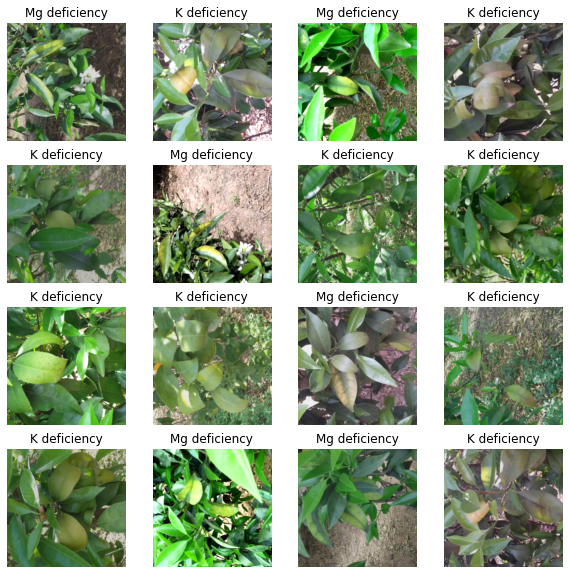

<IPython.core.display.Javascript object>

In [34]:
imshow(dataloaders, class_names)

#### Setting CUDA configuration if available

In [35]:
# Using CUDA if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

<IPython.core.display.Javascript object>

#### Training / Fine-Tuning Models

In [36]:
# Loading and Training architectures
model_ft_sgd_lr4 = get_architecture()
model_ft_sgd_lr4, ft_val_acc_history_sgd_lr4 = train_model(
    model_ft_sgd_lr4, optimizer_name="sgd", learning_rate=0.0001, num_epochs=NUM_EPOCHS
)

model_ft_adam_lr4 = get_architecture()
model_ft_adam_lr4, ft_val_acc_history_adam_lr4 = train_model(
    model_ft_adam_lr4,
    optimizer_name="adam",
    learning_rate=0.0001,
    num_epochs=NUM_EPOCHS,
)

Epoch 0/24
----------
train Loss: 0.7210 Acc: 0.4355 ||| val Loss: 0.7071 Acc: 0.3125
Epoch 1/24
----------
train Loss: 0.7055 Acc: 0.4839 ||| val Loss: 0.7061 Acc: 0.3125
Epoch 2/24
----------
train Loss: 0.6815 Acc: 0.5000 ||| val Loss: 0.7052 Acc: 0.3125
Epoch 3/24
----------
train Loss: 0.7154 Acc: 0.4516 ||| val Loss: 0.7041 Acc: 0.3750
Epoch 4/24
----------
train Loss: 0.6907 Acc: 0.5323 ||| val Loss: 0.7032 Acc: 0.3125
Epoch 5/24
----------
train Loss: 0.6929 Acc: 0.5323 ||| val Loss: 0.7024 Acc: 0.3125
Epoch 6/24
----------
train Loss: 0.6840 Acc: 0.5484 ||| val Loss: 0.7017 Acc: 0.3750
Epoch 7/24
----------
train Loss: 0.6821 Acc: 0.5645 ||| val Loss: 0.7009 Acc: 0.3750
Epoch 8/24
----------
train Loss: 0.6893 Acc: 0.5323 ||| val Loss: 0.7001 Acc: 0.3750
Epoch 9/24
----------
train Loss: 0.7028 Acc: 0.5161 ||| val Loss: 0.6993 Acc: 0.4375
Epoch 10/24
----------
train Loss: 0.6842 Acc: 0.5645 ||| val Loss: 0.6985 Acc: 0.4375
Epoch 11/24
----------
train Loss: 0.6737 Acc: 0.6613

<IPython.core.display.Javascript object>

In [ ]:
# Loading and Training architectures
model_ft_sgd_lr2 = get_architecture()
model_ft_sgd_lr2, ft_val_acc_history_sgd_lr2 = train_model(model_ft_sgd_lr2,
                                                optimizer_name="sgd", 
                                                learning_rate=0.01,
                                                num_epochs=NUM_EPOCHS)

model_ft_adam_lr2 = get_architecture()
model_ft_adam_lr2, ft_val_acc_history_adam_lr2 = train_model(model_ft_adam_lr2,
                                                optimizer_name="adam", 
                                                learning_rate=0.01,
                                                num_epochs=NUM_EPOCHS)

Epoch 0/24
----------
train Loss: 0.7495 Acc: 0.4677 ||| val Loss: 0.6493 Acc: 0.6250
Epoch 1/24
----------
train Loss: 0.6113 Acc: 0.6290 ||| val Loss: 0.6277 Acc: 0.6875
Epoch 2/24
----------
train Loss: 0.5543 Acc: 0.8387 ||| val Loss: 0.6106 Acc: 0.6875
Epoch 3/24
----------
train Loss: 0.5497 Acc: 0.7097 ||| val Loss: 0.5909 Acc: 0.7500
Epoch 4/24
----------
train Loss: 0.4756 Acc: 0.8710 ||| val Loss: 0.5791 Acc: 0.7500
Epoch 5/24
----------
train Loss: 0.5170 Acc: 0.7903 ||| val Loss: 0.5654 Acc: 0.7500
Epoch 6/24
----------
train Loss: 0.4325 Acc: 0.9032 ||| val Loss: 0.5554 Acc: 0.7500
Epoch 7/24
----------
train Loss: 0.5315 Acc: 0.7581 ||| val Loss: 0.5462 Acc: 0.9375
Epoch 8/24
----------
train Loss: 0.4807 Acc: 0.7903 ||| val Loss: 0.5571 Acc: 0.6875
Epoch 9/24
----------
train Loss: 0.4530 Acc: 0.8387 ||| val Loss: 0.5325 Acc: 0.7500
Epoch 10/24
----------
train Loss: 0.3914 Acc: 0.9032 ||| val Loss: 0.5249 Acc: 0.7500
Epoch 11/24
----------
train Loss: 0.3808 Acc: 0.8710

#### Plotting Performances

In [ ]:
# Preparing performances for being plotted
performances = [("SGD-0.01", ft_val_acc_history_sgd_lr2),
                ("Adam-0.01", ft_val_acc_history_adam_lr2), 
                ("SGD-0.0001", ft_val_acc_history_sgd_lr4), 
                ("Adam-0.0001", ft_val_acc_history_adam_lr4)]

In [ ]:
plot_performances(performances)

In [ ]:
shutil.rmtree(os.path.join(SRC_PATH, DST_FOLDER_NAME))

## Possible Extensions
1. Use a different pre-trained network.
2. Try a different training approach where pre-trained weights are not loaded.
3. Try different epochs and batch sizes.

## Bibliography

https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

https://www.oreilly.com/library/view/programming-pytorch-for/9781492045342/ch04.html